# Commodity Food Pricing: Model Experiments

**By:** `MSOE AI-Club "Nourish" Student Research Team`<br/>
**Primary Notebook Developer:** Ben Paulson, ____

**Notebook Purpose:** To explore the use of machine learning to predict the price of commodities in the food industry. By utilizing the clean datasets loaded from `data_analysis.ipynb` into the directory `model_data`, we can begin to explore the use of machine learning to predict the price of commodities in the food industry. This notebook will be divided into sections of varying complexity, each of which will explore a different model type and its performance on the data. The models will be evaluated based on their ability to predict the price of a commodity in the future, given a set of features. The features will be selected based on their correlation to the price of the commodity, as determined in `data_analysis.ipynb`. There is also significant documentation with each section for both code/purpose sanity, sake of future reproducibility, and to help other members of the `MSOE AI-Club "Nourish" Student Research Team` understand the code and its purpose.
* **Part 1: Loading the Experiment(s) Data**
* **Part 2: Building Complex ML Models**
    * **Model 1:** Simple, 1-layer Transformer
    * **Model 2:** ...
* **Part 3: Experiments with Training Methods**
    * **Method 1:** ...
    * **Method 2:** ...

**Research Context:** This research is being conducted as part of the MSOE AI-Club's "Nourish" project, which aims to use machine learning to predict future food prices in order to help farmers in developing countries make better decisions about food storage and crop selection, achieved through the accurate warning administration and prediction of food commodity pricing data by country and food market. This project is pending as part of a relationship with the United Nation's Food and Agriculture Organization (FAO). [FAO Official Statement on the Importance of Research Like This](https://youtu.be/sZx3hhnEHiI)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [119]:
# Retrieve the data for model usage
model_data = pd.read_csv('model_data/argentina_wheat_model_data.csv', index_col=0)

## Part 1: Loading the Experiment(s) Data
Based on the data retrieved from `data_analysis.ipynb`, get that data into a format capable of being used by a Machine Learning model.

In [130]:
N_TREND_SAMPLES = 3
TEST_SIZE = 0.2
OUTPUT_COLUMN_NAME = 'Price'

num_input_samples = len(model_data.columns[2:-1]) + N_TREND_SAMPLES

In [122]:
def grab_n_previous_prices(model_data, n):
    """
    For the given model_data, grab the n previous prices and store as a list
    in a new column called 'n_previous_prices' for each row's associated 'Date'.
    The current date's price should not be included in the list of previous prices.
    :param pd.DataFrame model_data: data (model_data to grab from)
    :param int n: Number of previous prices to grab
    """
    # Create a new column to store the n_previous_prices
    model_data['n_previous_prices'] = None

    # Iterate through each row
    for index, row in model_data.iterrows():
        # Grab the date and price for the current row
        date = row['Date']
        price = row['Price']

        # Grab the n previous prices
        n_previous_prices = model_data.loc[model_data['Date'] < date]['Price'].tail(n).tolist()

        # Store the n_previous_prices in the new column
        model_data.at[index, 'n_previous_prices'] = n_previous_prices

    return model_data

In [123]:
def divide_inputs_and_outputs(row):
    """
    Create a column to specifically be input into an ML model and a column for output
    :param pd.DataFrame row: row to divide

    :return: row with input and output columns
    """
    output = row[OUTPUT_COLUMN_NAME]
    inputs = row[2:-1].tolist()

    # For each element in n_previous_price, add it to the inputs
    for price in row['n_previous_prices']:
        inputs.append(price)

    return pd.Series([inputs, output], index=['inputs', 'output'])

In [206]:
def format_for_ML_usage(inputs, outputs):
    """
    Given the inputs and outputs for the model, format the data to be used for ML.
    This is accomplished by splitting the data into training/test tensors
    :param inputs: inputs for the model (list of lists)
    :param output: output for the model (list of values)

    :return: The tensors responsible for testing/training the model and the scaler used to scale the data
            (x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler)
    """
    # Create a train/test split for the dataset
    x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=TEST_SIZE, shuffle=False)

    # Convert them all to numpy arrays
    x_train = np.array(x_train).reshape(-1, num_input_samples)
    x_test = np.array(x_test).reshape(-1, num_input_samples)
    y_train = np.array(y_train).reshape(-1, 1) # required reshape for StandardScaler
    y_test = np.array(y_test).reshape(-1, 1) # required reshape for StandardScaler

    # Standardize/Normalize the dataset
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train).reshape(-1, num_input_samples, 1)
    x_test_scaled = scaler.transform(x_test).reshape(-1, num_input_samples, 1)
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)

    # Convert to tensors for model ingestion (true training data)
    x_train_tensor = tf.convert_to_tensor(x_train_scaled)
    x_test_tensor = tf.convert_to_tensor(x_test_scaled)
    y_train_tensor = tf.convert_to_tensor(y_train_scaled)
    y_test_tensor = tf.convert_to_tensor(y_test_scaled)

    return (x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler)

In [204]:
# Sort model data where the earliest date comes first and the latest date comes last
model_data = model_data.sort_values(by='Date', ascending=True)
model_data = grab_n_previous_prices(model_data, N_TREND_SAMPLES)

# Remove rows where the len(n_previous_prices) != N_TREND_SAMPLES
model_data = model_data[model_data['n_previous_prices'].apply(lambda x: len(x) == N_TREND_SAMPLES)]
model_data

,Date,Price,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment,n_previous_prices
161,2003-05-01,0.327689,0.284869,0.452335,0.430506,344.21875,2936474.0,1.0,"[0.3052158461377652, 0.3120100344935716, 0.298..."
160,2003-06-01,0.330302,0.284869,0.450416,0.426973,315.45000,2936474.0,1.0,"[0.3120100344935716, 0.2981080798578447, 0.327..."
159,2003-07-01,0.296854,0.284869,0.456174,0.418139,320.81250,2936474.0,1.0,"[0.2981080798578447, 0.3276889306992788, 0.330..."
158,2003-08-01,0.320268,0.284869,0.463212,0.443463,361.75000,2936474.0,1.0,"[0.3276889306992788, 0.3303020800668966, 0.296..."
157,2003-09-01,0.317341,0.284869,0.472169,0.448174,348.03125,2936474.0,1.0,"[0.3303020800668966, 0.2968537681613881, 0.320..."
...,...,...,...,...,...,...,...,...,...
4,2016-08-01,0.449462,0.252506,0.648752,0.559482,402.43750,2679728.0,1.0,"[0.422284937807045, 0.4390090937597993, 0.4390..."
3,2016-09-01,0.420717,0.252506,0.653871,0.540636,407.78125,2679728.0,1.0,"[0.4390090937597993, 0.4390090937597993, 0.449..."
2,2016-10-01,0.384656,0.252506,0.653231,0.543581,414.17500,2679728.0,1.0,"[0.4390090937597993, 0.4494616912302707, 0.420..."
1,2016-11-01,0.368768,0.252506,0.651951,0.538869,408.40625,2679728.0,1.0,"[0.4494616912302707, 0.4207170481864744, 0.384..."


In [209]:
inputs_and_outputs = model_data.apply(divide_inputs_and_outputs, axis=1)
inputs = inputs_and_outputs['inputs'].tolist(); outputs = inputs_and_outputs['output'].tolist()
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=TEST_SIZE, shuffle=False) # Don't shuffle, should be cohesive samples not seen
x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler = format_for_ML_usage(inputs, outputs)

print('x_train_tensor shape:', x_train_tensor.shape)
print('x_test_tensor shape:', x_test_tensor.shape)
print('y_train_tensor shape:', y_train_tensor.shape)
print('y_test_tensor shape:', y_test_tensor.shape)

x_train_tensor shape: (129, 9, 1)
x_test_tensor shape: (33, 9, 1)
y_train_tensor shape: (129, 1)
y_test_tensor shape: (33, 1)


## Part 2: Building Complex ML Models

In [214]:
# Define positional encoding function (another portion for data preprocessing)
def positional_encoding(length, depth):
    """ 
    Create positional encoding
    args:
        length: length of the sequence
        depth: depth of the model
    """
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / depth) for j in range(depth)]
        for pos in range(length)
    ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return tf.cast(pos_enc, dtype=tf.float32)

### Model 1: Simple, 1-Layer Transformer

In [89]:
model_data.shape[1]

9

In [211]:
HEAD_SIZE = 64
NUM_HEADS = 16
FF_DIM = 16

d_model = x_train_tensor.shape[-1] 
length = x_train_tensor.shape[1]  

In [215]:
def transformer(head_size, num_heads, ff_dim, dropout=0):
    """
    Building a simple transformer based off the original work compiled in
    the research paper "Attention Is All You Need" (https://arxiv.org/pdf/1706.03762.pdf)
    :param int head_size: Size of the attention heads
    :param int num_heads: Number of heads
    :param int ff_dim: Feed forward dimension
    :param float dropout: Dropout rate
    """
    
    # Input Layer
    inputs = tf.keras.layers.Input(shape=(num_input_samples, d_model))

    # Add positional encoding to the input
    # The positional encoding is added to the input in order to give the model some information about the relative position of the words in the sequence
    # Not including the positional encoding is basically the same as randomizing the order of the data
    positional_inputs = inputs + positional_encoding(num_input_samples, d_model)
    
    # Multi-Head Attention
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(positional_inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    # Add & Norm
    res = x + positional_inputs  # Skip connection
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    
    # Feed-Forward Network (Using Dense layers instead of Conv1D layers)
    x = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    # Skip Connection
    x = x + res

    # Global Average Pooling layer
    # The Global Average Pooling layer reduces the dimensionality/complexity of the data
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Output Layer
    outputs = tf.keras.layers.Dense(1)(x)

    return inputs, outputs

In [216]:
inputs,outputs = transformer(HEAD_SIZE, NUM_HEADS, FF_DIM)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()

## Part 3: Experiments with Training Methods

In [167]:
NUM_EPOCHS = 100
BATCH_SIZE = 16

In [200]:
# Train the model on our training data (train tensors)
history = model.fit(
    x_train_tensor, y_train_tensor,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/100
9/9 [==============================] - 2s 10ms/step - loss: nan
Epoch 2/100
9/9 [==============================] - 0s 9ms/step - loss: nan
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: nan
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: nan
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: nan
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: nan
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: nan
Epoch 8/100
9/9 [==============================] - 0s 6ms/step - loss: nan
Epoch 9/100
9/9 [==============================] - 0s 7ms/step - loss: nan
Epoch 10/100
9/9 [==============================] - 0s 7ms/step - loss: nan
Epoch 11/100
9/9 [==============================] - 0s 6ms/step - loss: nan
Epoch 12/100
9/9 [==============================] - 0s 6ms/step - loss: nan
Epoch 13/100
9/9 [==============================] - 0s 6ms/step - loss: nan
Epoch 14/100
9/9 [==

ValueError: x and y must be the same size

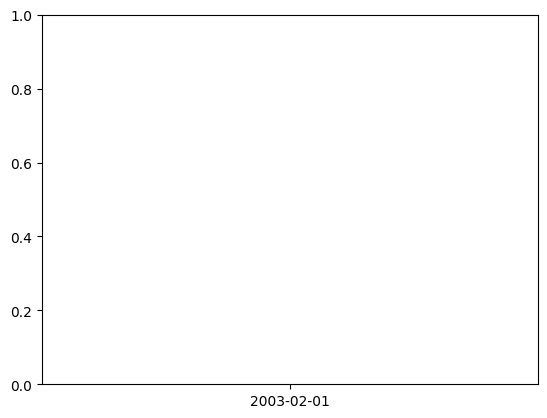

In [185]:
# Plot the prediction result
dates = model_data['Date'].tolist()
plt.scatter(dates, y_pred, color='red', label='Predicted Values')
plt.scatter(dates, y_test, color='blue', label='Actual Values') 
plt.xlabel('Months Since September 2010')
plt.ylabel('Cost Index of Crop Products in Nigerian Naira')
plt.title('Actual vs Predicted Values with Transformer')
plt.legend()
plt.show()